In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import f_regression
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import pickle
import pandas as pd
pd.set_option('display.max_columns', 300)


## Step 1: Read in hold out data, scalers, and best model

In [7]:
holdout = pd.read_csv('kc_house_data_train.csv', index_col=0)

In [8]:
final_scaler = open('scaler.pickle', 'wb')
final_model = pickle.load(open('model.pickle', 'rb'))

## Step 2: Feature Engineering for holdout set

Remember we have to perform the same transformations on our holdout data (feature engineering, extreme values, and scaling) that we performed on the original data.

In [10]:
holdout = pd.read_csv('kc_house_data_train.csv', sep=',', index_col=0)
pd.options.display.float_format = '{:.4f}'.format
holdout.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000,4,2.2500,2070,8893,2.0000,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.1620,2390,7700
1,7974200820,20140821T000000,865000,5,3.0000,2900,6730,1.0000,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.2850,2370,6283
2,7701450110,20140815T000000,1038000,4,2.5000,3770,10893,2.0000,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.1290,3710,9685
3,9522300010,20150331T000000,1490000,3,3.5000,4560,14608,2.0000,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.2280,4050,14226
4,9510861140,20140714T000000,711000,3,2.5000,2550,5376,2.0000,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.0830,2250,4050


In [11]:
holdout.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000,17290.0000
mean,4565501756.4366,540739.5486,3.3725,2.1119,2081.4646,15243.3999,1.4903,0.0080,0.2385,3.4085,7.6544,1789.3060,292.1586,1970.7920,83.8063,98078.1932,47.5601,-122.2143,1987.9867,12873.4758
std,2874655595.3624,373318.9787,0.9393,0.7705,920.0185,42304.6238,0.5389,0.0890,0.7752,0.6513,1.1747,829.2651,443.1519,29.3435,400.3294,53.6079,0.1384,0.1409,684.8026,27227.4376
min,1000102.0000,75000.0000,0.0000,0.0000,290.0000,572.0000,1.0000,0.0000,0.0000,1.0000,1.0000,290.0000,0.0000,1900.0000,0.0000,98001.0000,47.1559,-122.5190,399.0000,659.0000
25%,2114700558.7500,321000.0000,3.0000,1.5000,1430.0000,5081.2500,1.0000,0.0000,0.0000,3.0000,7.0000,1200.0000,0.0000,1951.0000,0.0000,98033.0000,47.4712,-122.3290,1490.0000,5111.2500
50%,3903650042.5000,450000.0000,3.0000,2.2500,1920.0000,7642.0000,1.5000,0.0000,0.0000,3.0000,7.0000,1560.0000,0.0000,1974.0000,0.0000,98065.0000,47.5716,-122.2300,1840.0000,7622.5000
75%,7301150051.5000,645000.0000,4.0000,2.5000,2550.0000,10725.7500,2.0000,0.0000,0.0000,4.0000,8.0000,2214.5000,560.0000,1996.0000,0.0000,98118.0000,47.6779,-122.1260,2360.0000,10101.7500
max,9900000190.0000,7700000.0000,33.0000,8.0000,13540.0000,1651359.0000,3.5000,1.0000,4.0000,5.0000,13.0000,9410.0000,4820.0000,2015.0000,2015.0000,98199.0000,47.7776,-121.3150,6210.0000,858132.0000


In [12]:
holdout['id'].nunique()

17176

In [13]:
holdout_no_dup = holdout.drop_duplicates(subset=['id']).copy()
holdout_no_dup.shape

(17176, 21)

In [14]:
holdout_no_dup.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000,17176.0000
mean,4565580286.9302,541603.6480,3.3727,2.1138,2083.7979,15288.1047,1.4918,0.0080,0.2393,3.4090,7.6582,1791.3828,292.4151,1970.8570,84.1318,98078.1242,47.5602,-122.2141,1989.4009,12903.7003
std,2874305686.6260,373674.3071,0.9389,0.7706,921.0907,42439.6199,0.5392,0.0893,0.7761,0.6510,1.1749,830.2539,443.4962,29.3547,401.0759,53.5672,0.1384,0.1410,685.3508,27312.4494
min,1000102.0000,75000.0000,0.0000,0.0000,290.0000,572.0000,1.0000,0.0000,0.0000,1.0000,1.0000,290.0000,0.0000,1900.0000,0.0000,98001.0000,47.1559,-122.5190,399.0000,659.0000
25%,2115432651.2500,322500.0000,3.0000,1.7500,1430.0000,5080.0000,1.0000,0.0000,0.0000,3.0000,7.0000,1200.0000,0.0000,1951.0000,0.0000,98033.0000,47.4713,-122.3290,1490.0000,5110.0000
50%,3902300280.0000,450000.0000,3.0000,2.2500,1920.0000,7641.5000,1.5000,0.0000,0.0000,3.0000,7.0000,1570.0000,0.0000,1975.0000,0.0000,98065.0000,47.5718,-122.2290,1840.0000,7623.0000
75%,7300410022.5000,647125.0000,4.0000,2.5000,2550.0000,10732.2500,2.0000,0.0000,0.0000,4.0000,8.0000,2220.0000,560.0000,1996.0000,0.0000,98118.0000,47.6780,-122.1250,2360.0000,10112.2500
max,9900000190.0000,7700000.0000,33.0000,8.0000,13540.0000,1651359.0000,3.5000,1.0000,4.0000,5.0000,13.0000,9410.0000,4820.0000,2015.0000,2015.0000,98199.0000,47.7776,-121.3150,6210.0000,858132.0000


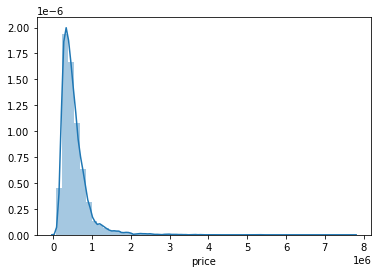

In [15]:
sns.distplot(holdout_no_dup['price'])

In [16]:
q = holdout_no_dup['price'].quantile(0.99)
data = holdout_no_dup[holdout_no_dup['price']<q]
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000,17004.0000
mean,4572403212.9029,518772.7669,3.3629,2.0962,2053.7053,15205.3027,1.4876,0.0056,0.2201,3.4079,7.6268,1768.7655,284.9398,1970.8464,82.1628,98078.2241,47.5596,-122.2138,1973.9906,12843.9528
std,2874837652.2133,284410.9902,0.9332,0.7459,859.7747,42429.4916,0.5382,0.0749,0.7366,0.6499,1.1328,791.5522,430.3879,29.2808,396.5520,53.5425,0.1389,0.1414,666.9102,27325.4289
min,1000102.0000,75000.0000,0.0000,0.0000,290.0000,572.0000,1.0000,0.0000,0.0000,1.0000,1.0000,290.0000,0.0000,1900.0000,0.0000,98001.0000,47.1559,-122.5190,399.0000,659.0000
25%,2122039126.2500,320000.0000,3.0000,1.5000,1430.0000,5054.7500,1.0000,0.0000,0.0000,3.0000,7.0000,1190.0000,0.0000,1951.0000,0.0000,98033.0000,47.4693,-122.3290,1490.0000,5100.0000
50%,3904902135.0000,450000.0000,3.0000,2.2500,1910.0000,7609.5000,1.5000,0.0000,0.0000,3.0000,7.0000,1560.0000,0.0000,1974.0000,0.0000,98065.0000,47.5707,-122.2290,1830.0000,7611.0000
75%,7303475442.5000,637062.5000,4.0000,2.5000,2520.0000,10608.2500,2.0000,0.0000,0.0000,4.0000,8.0000,2190.0000,550.0000,1996.0000,0.0000,98118.0000,47.6783,-122.1240,2340.0000,10050.7500
max,9900000190.0000,1998000.0000,33.0000,7.5000,7730.0000,1651359.0000,3.5000,1.0000,4.0000,5.0000,12.0000,7320.0000,3260.0000,2015.0000,2015.0000,98199.0000,47.7776,-121.3150,5790.0000,858132.0000


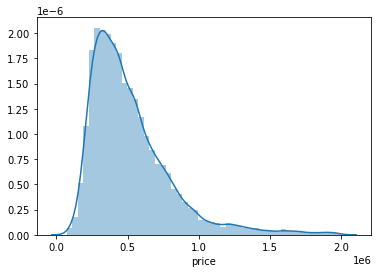

In [17]:
sns.distplot(data['price'])

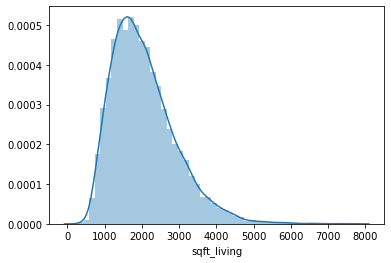

In [18]:
sns.distplot(data['sqft_living'])

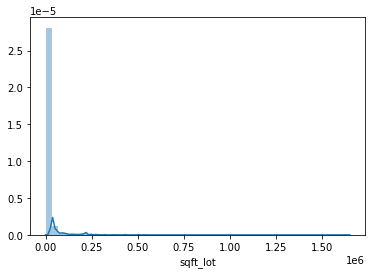

In [19]:
sns.distplot(data['sqft_lot'])

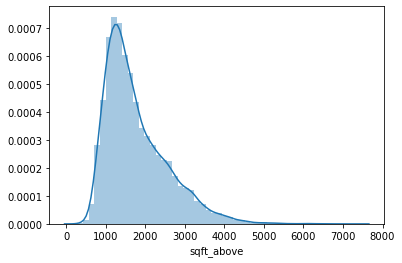

In [20]:
sns.distplot(data['sqft_above'])

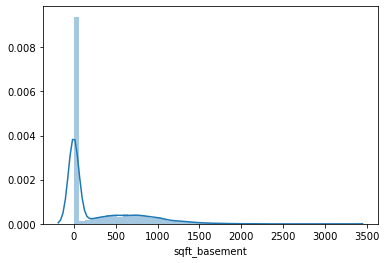

In [21]:
sns.distplot(data['sqft_basement'])

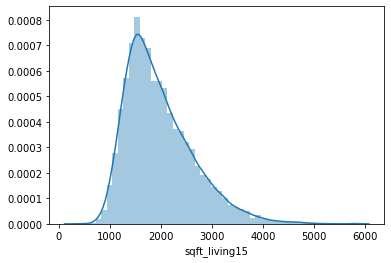

In [22]:
sns.distplot(data['sqft_living15'])

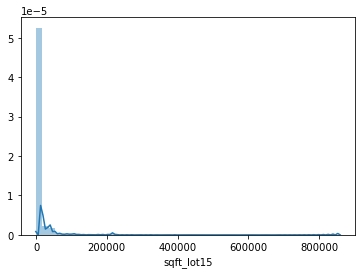

In [23]:
sns.distplot(data['sqft_lot15'])

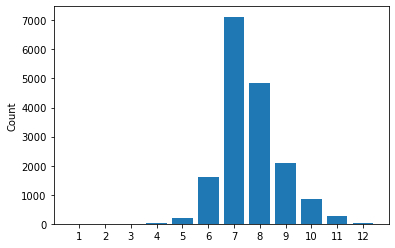

In [24]:
plt.hist(data['grade'], rwidth=.8, bins=np.arange(min(data['grade']), max(data['grade'])+2) - 0.5)
plt.xticks(np.arange(min(data['grade']), max(data['grade'])+1, 1.0))
plt.ylabel('Count')
plt.show()

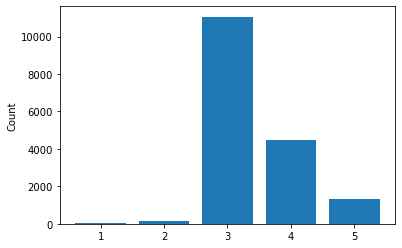

In [25]:
plt.hist(data['condition'], rwidth=.8, bins=np.arange(min(data['condition']), max(data['condition'])+2) - 0.5)
plt.xticks(np.arange(min(data['condition']), max(data['condition'])+1, 1.0))
plt.ylabel('Count')
plt.show()

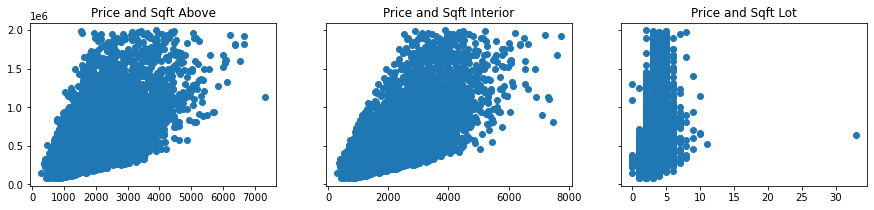

In [26]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data['sqft_above'],data['price'])
ax1.set_title('Price and Sqft Above')
ax2.scatter(data['sqft_living'],data['price'])
ax2.set_title('Price and Sqft Interior')
ax3.scatter(data['bedrooms'],data['price'])
ax3.set_title('Price and Sqft Lot')

plt.show()

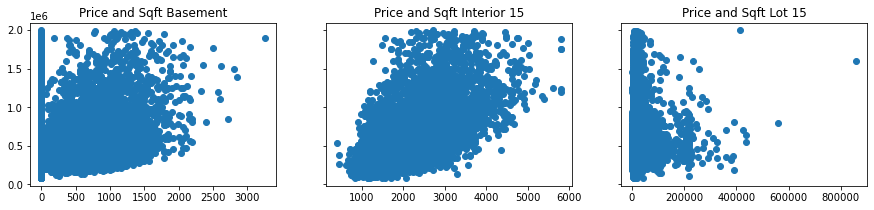

In [27]:
f, (ax4, ax5, ax6) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax4.scatter(data['sqft_basement'],data['price'])
ax4.set_title('Price and Sqft Basement')
ax5.scatter(data['sqft_living15'],data['price'])
ax5.set_title('Price and Sqft Interior 15')
ax6.scatter(data['sqft_lot15'],data['price'])
ax6.set_title('Price and Sqft Lot 15')

plt.show()

In [28]:
# Let's transform 'Price' with a log transformation
log_price = np.log(data['price'])

# Then we add it to our data frame
data['log_price'] = log_price
data

<ipython-input-28-73c69f7531b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_price'] = log_price


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,2591820310,20141006T000000,365000,4,2.2500,2070,8893,2.0000,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.1620,2390,7700,12.8077
1,7974200820,20140821T000000,865000,5,3.0000,2900,6730,1.0000,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.2850,2370,6283,13.6705
2,7701450110,20140815T000000,1038000,4,2.5000,3770,10893,2.0000,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.1290,3710,9685,13.8528
3,9522300010,20150331T000000,1490000,3,3.5000,4560,14608,2.0000,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.2280,4050,14226,14.2143
4,9510861140,20140714T000000,711000,3,2.5000,2550,5376,2.0000,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.0830,2250,4050,13.4744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000,5,2.5000,3240,9960,1.0000,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.1120,2730,10400,13.5278
17286,8819900270,20140520T000000,440000,2,1.7500,1300,4000,2.0000,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.2880,1350,4013,12.9945
17287,3816300095,20140514T000000,310000,3,1.0000,1050,9876,1.0000,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.2620,1760,9403,12.6443
17288,122069107,20141204T000000,427500,3,1.5000,1900,43186,1.5000,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.9900,2080,108028,12.9657


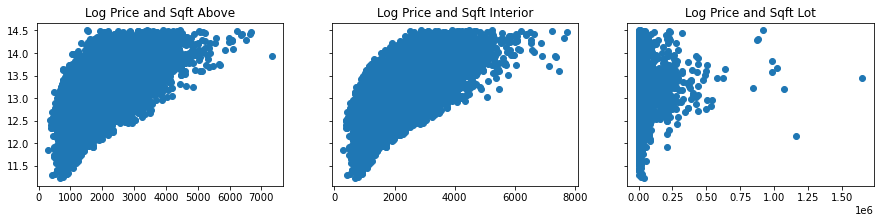

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data['sqft_above'],data['log_price'])
ax1.set_title('Log Price and Sqft Above')
ax2.scatter(data['sqft_living'],data['log_price'])
ax2.set_title('Log Price and Sqft Interior')
ax3.scatter(data['sqft_lot'],data['log_price'])
ax3.set_title('Log Price and Sqft Lot')

plt.show()

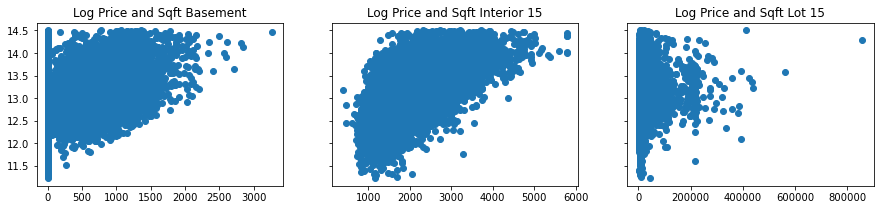

In [30]:
f, (ax4, ax5, ax6) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax4.scatter(data['sqft_basement'],data['log_price'])
ax4.set_title('Log Price and Sqft Basement')
ax5.scatter(data['sqft_living15'],data['log_price'])
ax5.set_title('Log Price and Sqft Interior 15')
ax6.scatter(data['sqft_lot15'],data['log_price'])
ax6.set_title('Log Price and Sqft Lot 15')

plt.show()

In [31]:
variables = data[['sqft_basement','sqft_living15','sqft_lot15','sqft_lot','sqft_living','sqft_above']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

/Users/jefelito/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Features
0,inf,sqft_basement
1,16.5479,sqft_living15
2,2.4265,sqft_lot15
3,2.2259,sqft_lot
4,inf,sqft_living
5,inf,sqft_above


The VIP values show very high multicollinearity between in continuous independent variables.

In [32]:
data_no_date = data.drop(columns = ['date']).copy()
data_no_date

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,2591820310,365000,4,2.2500,2070,8893,2.0000,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.1620,2390,7700,12.8077
1,7974200820,865000,5,3.0000,2900,6730,1.0000,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.2850,2370,6283,13.6705
2,7701450110,1038000,4,2.5000,3770,10893,2.0000,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.1290,3710,9685,13.8528
3,9522300010,1490000,3,3.5000,4560,14608,2.0000,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.2280,4050,14226,14.2143
4,9510861140,711000,3,2.5000,2550,5376,2.0000,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.0830,2250,4050,13.4744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,750000,5,2.5000,3240,9960,1.0000,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.1120,2730,10400,13.5278
17286,8819900270,440000,2,1.7500,1300,4000,2.0000,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.2880,1350,4013,12.9945
17287,3816300095,310000,3,1.0000,1050,9876,1.0000,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.2620,1760,9403,12.6443
17288,122069107,427500,3,1.5000,1900,43186,1.5000,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.9900,2080,108028,12.9657


In [33]:
# The target(s) (dependent variable) is 'log price'
y = data_no_date['price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
X = data_no_date.drop(['log_price','price'],axis=1)

In [34]:
# Split the variables with an 80-20 split and some random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)


Training set - Features:  (13603, 19) Target:  (13603,)
Training set - Features:  (3401, 19) Target:  (3401,)


In [48]:
# Instantiate the Standar Scaler Object.
final_scaler = StandardScaler()

# Fit and Transform the training data.
X_train = final_scaler.fit_transform(X_train)

# ONLY TRANSFORM the test data.
X_test = final_scaler.transform(X_test)

# Instantiate the Linear Regression Object.
final_model = LinearRegression()

# Fit the model to the transformed X_train, and the y_train.
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
# Score the model based on the transformed X_test and the y_test.

In [49]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 151652.78220892372


In [50]:
#use fitted model to predict on the test examples
y_test_pred = final_model.predict(X_test)

#evaluate the predictions on the test examples
btest_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

NameError: name 'test_rmse' is not defined

In [43]:
print ("R^2 Score:", lm.score(X_train, y_train))

R^2 Score: 0.713338534541775


In [44]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 105897.29951328882
Mean Squared Error: 22998566351.707253
Root Mean Squared Error: 151652.78220892372


Text(0.5, 1.0, 'Residuals PDF')

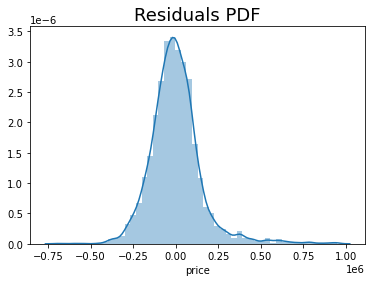

In [45]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_test- y_test_pred)

# Include a title
plt.title("Residuals PDF", size=18)

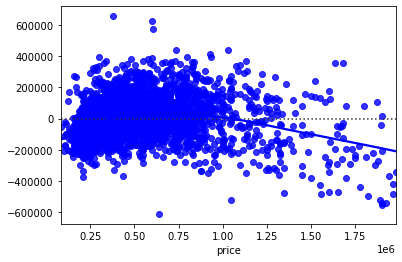

In [46]:
sns.residplot( y_test, y_test_pred,lowess=True, color="b")

## Step 3: Predict the holdout set

In [70]:
final_answer = final_model.predict(X_test)
final_answer

array([394106.29292133, 229046.52964025, 161095.69868539, ...,
       271084.24585729, 355729.96001754, 548089.02894332])

## Step 4: Export your predictions

In [71]:
final_answer = pd.DataFrame(final_answer, columns=['predictions']).to_csv('housing_preds_JeffreyMunoz.csv')